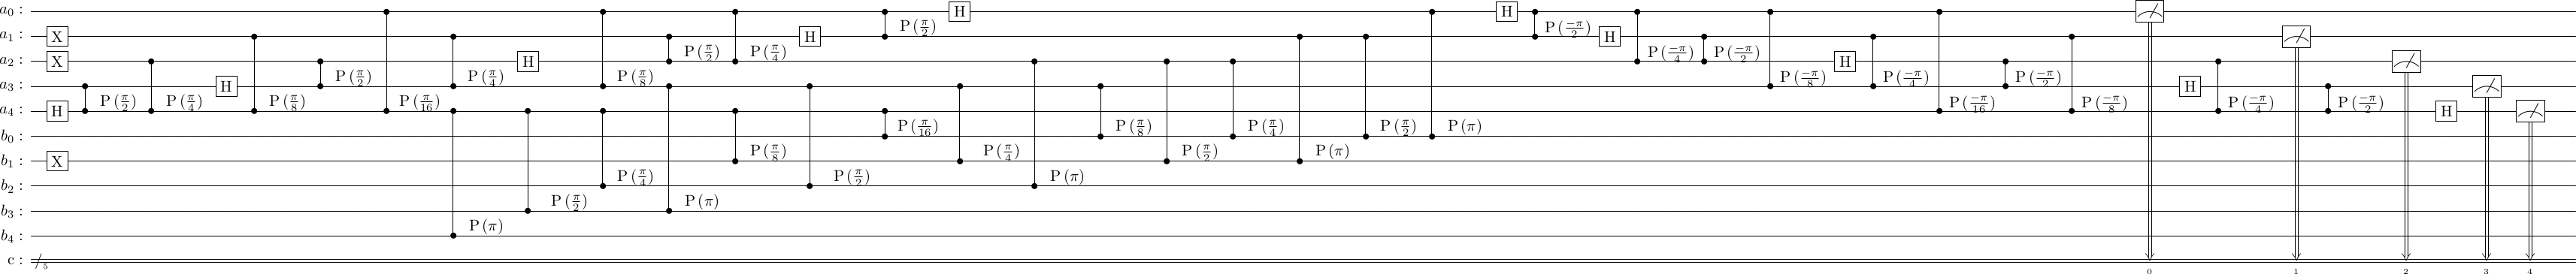

(8, {'01000': 1024})

In [5]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
import matplotlib.pyplot as plt
from qiskit.visualization import circuit_drawer
from IPython.display import display

class QuantumAdder:
    def __init__(self, n_bits=10):
        self.n_bits = n_bits  # Number of bits for the numbers
        self.simulator = Aer.get_backend('qasm_simulator')  # Correct simulator

    def create_input_state(self, qc, reg, n, pie):
        """Applies the quantum Fourier transform to the nth qubit."""
        qc.h(reg[n])
        for i in range(n):
            qc.cp(pie / (2 ** (i + 1)), reg[n - (i + 1)], reg[n])

    def evolve_qft_state(self, qc, reg_a, reg_b, n, pie):
        """Evolves the state |F(ψ(reg_a))> to |F(ψ(reg_a+reg_b))>."""
        for i in range(n + 1):
            qc.cp(pie / (2 ** i), reg_b[n - i], reg_a[n])

    def inverse_qft(self, qc, reg, n, pie):
        """Performs the inverse quantum Fourier transform on a register."""
        for i in range(n):
            qc.cp(-pie / (2 ** (n - i)), reg[i], reg[n])
        qc.h(reg[n])

    def decimal_to_binary(self, number):
        """Converts a decimal number to a binary string padded to `n_bits` length."""
        return bin(number)[2:].zfill(self.n_bits)

    def add_using_qft(self, a_val, b_val):
        """Adds two decimal numbers a_val and b_val using QFT-based addition."""
        pie = math.pi

        # Convert decimal inputs to binary strings
        a_bin = self.decimal_to_binary(a_val)
        b_bin = self.decimal_to_binary(b_val)

        # Initialize quantum and classical registers
        a = QuantumRegister(self.n_bits + 1, 'a')
        b = QuantumRegister(self.n_bits + 1, 'b')
        c = ClassicalRegister(self.n_bits + 1, 'c')
        qc = QuantumCircuit(a, b, c)

        # Encode binary values into qubits
        for i in range(self.n_bits):
            if a_bin[i] == "1":
                qc.x(a[self.n_bits - (i + 1)])
            if b_bin[i] == "1":
                qc.x(b[self.n_bits - (i + 1)])

        # Apply QFT on register a
        for i in range(self.n_bits + 1):
            self.create_input_state(qc, a, self.n_bits - i, pie)

        # Evolve the QFT state of a with b
        for i in range(self.n_bits + 1):
            self.evolve_qft_state(qc, a, b, self.n_bits - i, pie)

        # Apply inverse QFT on register a
        for i in range(self.n_bits + 1):
            self.inverse_qft(qc, a, i, pie)

        # Measure the result
        for i in range(self.n_bits + 1):
            qc.measure(a[i], c[i])

        return qc

    def run_addition(self, a_val, b_val):
        """Runs the QFT-based addition circuit and extracts the classical result."""
        qc = self.add_using_qft(a_val, b_val)

        # Simulate the circuit
        compiled_circuit = transpile(qc, self.simulator)
        result = self.simulator.run(compiled_circuit, shots=1024).result()

        # Get the most probable measurement outcome
        counts = result.get_counts()
        most_common = max(counts, key=counts.get)  # Get the most frequent bitstring
        result_val = int(most_common, 2)  # Convert to decimal

        return result_val, counts

quantum_adder = QuantumAdder(n_bits=4)  # Using 4-bit quantum adder
result_val, counts = quantum_adder.run_addition(6, 2)  # Compute 3 + 5
qc = quantum_adder.add_using_qft(6, 2)  # Get the quantum circuit used

circuit_drawer(qc, output='latex')  # Use 'mpl' for a Matplotlib-style output
display(qc.draw(output='latex'))
# Draw the circuit
#qc.draw("mpl")
plt.show()
#print(qc.draw())

result_val, counts
